# Supervised Multi-task Neural Network for Object Recognition and Orientation Detection
*Zhiang Chen, March 2017*

The orientation of the object is reduced to 1-DOF, yaw. The orientation detection is composed of two phases. In the first phase, the network classifies the orientation of the object into 10 classes. The second phase computes the expectation of these 10 classes to get the predicted orientation.

This notebook deals with **cropped images**.

### 1. Import necessary packages

In [2]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import random
import operator
import time
import os
import math
import deepdish as dd

### 2. Import data

In [5]:
wd = os.getcwd()
os.chdir('..')
file_name = 'depth_data.h5'

save = dd.io.load(file_name)

train_objects = save['train_objects']
train_orientations = save['train_orientations']
train_values = save['train_values']
valid_objects = save['valid_objects']
valid_orientations = save['valid_orientations']
valid_values = save['valid_values']
test_objects = save['test_objects']
test_orientations = save['test_orientations']
test_values = save['test_values']
value2object = save['value2object']
object2value = save['object2value']
del save

os.chdir(wd)

print('training dataset', train_objects.shape, train_orientations.shape, train_values.shape)
print('validation dataset', valid_objects.shape, valid_orientations.shape, valid_values.shape)
print('testing dataset', test_objects.shape, test_orientations.shape, test_values.shape)

('training dataset', (427626, 11), (427626, 10), (427626, 40, 40, 1))
('validation dataset', (71280, 11), (71280, 10), (71280, 40, 40, 1))
('testing dataset', (71280, 11), (71280, 10), (71280, 40, 40, 1))


### 3. Shuffle data

In [6]:
def randomize(dataset, classes, angles):
    permutation = np.random.permutation(classes.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_classes = classes[permutation]
    shuffled_angles = angles[permutation]
    return shuffled_dataset, shuffled_classes, shuffled_angles

train_dataset, train_classes, train_angles = randomize(train_values, train_objects, train_orientations)
valid_dataset, valid_classes, valid_angles = randomize(valid_values, valid_objects, valid_orientations)
test_dataset, test_classes, test_angles = randomize(test_values, test_objects, test_orientations)

valid_dataset = valid_dataset[:5000,:,:,:]
valid_angles = valid_angles[:5000,:]
valid_classes = valid_classes[:5000,:]

test_dataset = test_dataset[:5000,:,:,:]
test_angles = test_angles[:5000,:]
test_classes = test_classes[:5000,:]

### 4. Verify data

class: sponge
orientation: 162


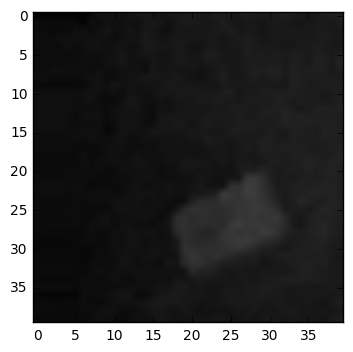

class: gstick
orientation: 0


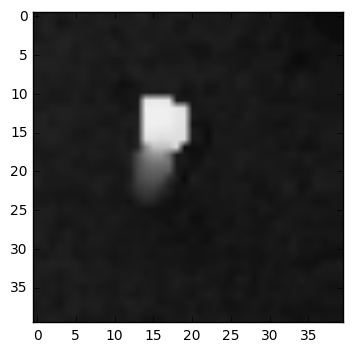

class: tball
orientation: 0


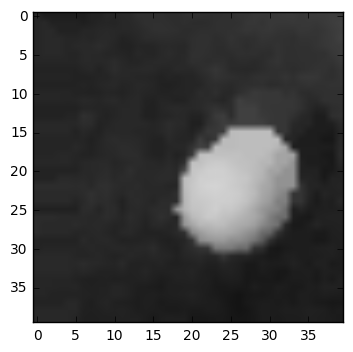

In [7]:
image_size = 40

def visualize(dataset, classes, angles, index):
    image = dataset[index,:,:].reshape(image_size, image_size).astype(np.float32)
    clas = classes[index,:]
    angle = angles[index,:]
    print('class: %s' % value2object[np.argmax(clas)])
    print('orientation: %d' % (np.argmax(angle)*18))
    plt.imshow(image,cmap='Greys_r',vmin=-0.6,vmax=0.4)
    plt.show()
    
visualize(train_dataset, train_classes, train_angles, random.randint(0,train_dataset.shape[0]))
visualize(valid_dataset, valid_classes, valid_angles, random.randint(0,valid_dataset.shape[0]))
visualize(test_dataset, test_classes, test_angles, random.randint(0,test_dataset.shape[0]))

### 5. Define some functions

In [8]:
def leaky_relu(x, leak=0.1):
    return tf.maximum(x, x * leak)

### 5. Build network
- Xavier initialization
- Batch normalization
- Leaky ReLU
- Replace all pooling layers
- Dropout

`
Convolutional Extractor
image: (50x50x1)
k1: (6x6,s=1)
map1: (45x45x16)
k2: (3x3,s=2)
map2: (22x22x16)
k3: (6x6,s=1)
map3: (17x17x32)
k4: (3x3,s=2)
map4: (8x8x32)
k5: (3x3,s=1)
map5: (6x6x64)
k6: (2x2,s=2)
map6: (3x3x64)
`

`
FC Object Classifier
f1: 120
f2: 60
`

`
FC Orientation Classifier
f1: 120
f2: 60
`

In [19]:
##--- Hyperparameters ---##
image_size = 40
'''ConvNet'''
k1_size = 6
k1_stride = 1
k1_depth = 1
k1_nm = 16
n1 = image_size*image_size*1

k2_size = 3
k2_stride = 2
k2_depth = 16
k2_nm = 16
m1_size = image_size-k1_size+k1_stride
n2 = m1_size*m1_size*k1_nm

k3_size = 6
k3_stride = 1
k3_depth = 16
k3_nm = 32
m2_size = (m1_size-k2_size)/k2_stride+1
n3 = m2_size*m2_size*k2_nm

k4_size = 3
k4_stride = 2
k4_depth = 32
k4_nm = 32
m3_size = (m2_size-k3_size)/k3_stride+1
n4 = m3_size*m3_size*k3_nm

k5_size = 3
k5_stride = 1
k5_depth = 32
k5_nm = 64
m4_size = (m3_size-k4_size)/k4_stride+1
n5 = m4_size*m4_size*k4_nm

k6_size = 2
k6_stride = 2
k6_depth = 64
k6_nm = 64
m5_size = (m4_size-k5_size)/k5_stride+1
n6 = m5_size*m5_size*k5_nm

'''Class FC'''
f7_class_size = 120
m6_class_size = (m5_size-k6_size)/k6_stride+1
n7_class = m6_class_size*m6_class_size*k6_nm

f8_class_size = 60
n8_class = f7_class_size

classes_size = 11
n9_class = f8_class_size

'''Angle FC'''
f7_angle_size = 120
m6_angle_size = (m5_size-k6_size)/k6_stride+1
n7_angle = m6_angle_size*m6_angle_size*k6_nm

f8_angle_size = 60
n8_angle = f7_angle_size

angles_size = 10
n9_angle = f8_angle_size

'''Dropout'''
keep_prob1 = 0.8
keep_prob2 = 0.5

'''Mini-batch'''
batch_size = 44

##--- Network ---##
graph = tf.Graph()

with graph.as_default():
    '''Input data'''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, k1_depth))
    # k1_depth = input_channels
    # convolution's input is a tensor of shape [batch,in_height,in_width,in_channels]
    tf_train_classes = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_train_angles = tf.placeholder(tf.float32, shape=(batch_size, 10))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    '''Xavier initialization'''
    k1_stddev = math.sqrt(1.0/n1)
    k1_weights = tf.Variable(tf.truncated_normal([k1_size, k1_size, k1_depth, k1_nm], stddev = k1_stddev))
    k1_biases = tf.Variable(tf.zeros([k1_nm]))
    
    k2_stddev = math.sqrt(2.0/n2)
    k2_weights = tf.Variable(tf.truncated_normal([k2_size, k2_size, k2_depth, k2_nm], stddev = k2_stddev))
    k2_biases = tf.Variable(tf.zeros([k2_nm]))
    
    k3_stddev = math.sqrt(2.0/n3)
    k3_weights = tf.Variable(tf.truncated_normal([k3_size, k3_size, k3_depth, k3_nm], stddev = k3_stddev))
    k3_biases = tf.Variable(tf.zeros([k3_nm]))
    
    k4_stddev = math.sqrt(2.0/n4)
    k4_weights = tf.Variable(tf.truncated_normal([k4_size, k4_size, k4_depth, k4_nm], stddev = k4_stddev))
    k4_biases = tf.Variable(tf.zeros([k4_nm]))
    
    k5_stddev = math.sqrt(2.0/n5)
    k5_weights = tf.Variable(tf.truncated_normal([k5_size, k5_size, k5_depth, k5_nm], stddev = k5_stddev))
    k5_biases = tf.Variable(tf.zeros([k5_nm]))
    
    k6_stddev = math.sqrt(2.0/n6)
    k6_weights = tf.Variable(tf.truncated_normal([k6_size, k6_size, k6_depth, k6_nm], stddev = k6_stddev))
    k6_biases = tf.Variable(tf.zeros([k6_nm]))
    
    ## class FC
    f7_class_stddev = math.sqrt(2.0/n7_class)
    f7_class_weights = tf.Variable(tf.truncated_normal([n7_class, f7_class_size], stddev = f7_class_stddev))
    f7_class_biases = tf.Variable(tf.zeros([f7_class_size]))
    
    f8_class_stddev = math.sqrt(2.0/n8_class)
    f8_class_weights = tf.Variable(tf.truncated_normal([n8_class, f8_class_size], stddev = f8_class_stddev))
    f8_class_biases = tf.Variable(tf.zeros([f8_class_size]))
    
    f9_class_stddev = math.sqrt(2.0/n9_class)
    f9_class_weights = tf.Variable(tf.truncated_normal([n9_class, classes_size], stddev = f9_class_stddev))
    f9_class_biases = tf.Variable(tf.zeros([classes_size]))
    
    ## angle FC
    f7_angle_stddev = math.sqrt(2.0/n7_angle)
    f7_angle_weights = tf.Variable(tf.truncated_normal([n7_angle, f7_angle_size], stddev = f7_angle_stddev))
    f7_angle_biases = tf.Variable(tf.zeros([f7_angle_size]))
    
    f8_angle_stddev = math.sqrt(2.0/n8_angle)
    f8_angle_weights = tf.Variable(tf.truncated_normal([n8_angle, f8_angle_size], stddev = f8_angle_stddev))
    f8_angle_biases = tf.Variable(tf.zeros([f8_angle_size]))
    
    f9_angle_stddev = math.sqrt(2.0/n9_angle)
    f9_angle_weights = tf.Variable(tf.truncated_normal([n9_angle, angles_size], stddev = f9_angle_stddev))
    f9_angle_biases = tf.Variable(tf.zeros([angles_size]))
    
    #print n1,n2,n3,n4,n5,n6,n7,n8,n9
    #print k1_stddev,k2_stddev,k3_stddev,k4_stddev,k5_stddev,k6_stddev,f7_stddev,f8_stddev,f9_stddev
    
    '''Batch normalization initialization'''
    beta1 = tf.Variable(tf.zeros([k1_nm]))
    gamma1 = tf.Variable(tf.ones([k1_nm]))
    
    beta2 = tf.Variable(tf.zeros([k2_nm]))
    gamma2 = tf.Variable(tf.ones([k2_nm]))
    
    beta3 = tf.Variable(tf.zeros([k3_nm]))
    gamma3 = tf.Variable(tf.ones([k3_nm]))
    
    beta4 = tf.Variable(tf.zeros([k4_nm]))
    gamma4 = tf.Variable(tf.ones([k4_nm]))

    beta5 = tf.Variable(tf.zeros([k5_nm]))
    gamma5 = tf.Variable(tf.ones([k5_nm]))
    
    beta6 = tf.Variable(tf.zeros([k6_nm]))
    gamma6 = tf.Variable(tf.ones([k6_nm]))
    
    saver = tf.train.Saver()
    '''Models'''
    def train_model(data):
        conv = tf.nn.conv2d(data, k1_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta1,gamma1,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k2_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta2,gamma2,1e-5)
        hidden = leaky_relu(y)
     
        conv = tf.nn.conv2d(hidden, k3_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta3,gamma3,1e-5)
        hidden = leaky_relu(y)
         
        conv = tf.nn.conv2d(hidden, k4_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta4,gamma4,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k5_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta5,gamma5,1e-5)
        hidden = leaky_relu(y)
      
        conv = tf.nn.conv2d(hidden, k6_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta6,gamma6,1e-5)
        hidden = leaky_relu(y)
  
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]]) 
        
        ## class FC
        class_hidden_input = tf.nn.dropout(reshape,keep_prob1) # dropout on the input layer
        class_hidden = leaky_relu(tf.matmul(class_hidden_input, f7_class_weights) + f7_class_biases)
        class_hidden = tf.nn.dropout(class_hidden, keep_prob2) # dropout on the first FC layer
        class_fc = tf.matmul(class_hidden,f8_class_weights)
        class_hidden = leaky_relu(class_fc + f8_class_biases)
        fc_classes = tf.matmul(class_hidden,f9_class_weights)
        output_classes = fc_classes + f9_class_biases
        
        ## angle FC
        angle_hidden_input = tf.nn.dropout(reshape,keep_prob1) # dropout on the input layer
        angle_hidden = leaky_relu(tf.matmul(angle_hidden_input, f7_angle_weights) + f7_angle_biases)
        angle_hidden = tf.nn.dropout(angle_hidden, keep_prob2) # dropout on the first FC layer
        angle_fc = tf.matmul(angle_hidden,f8_angle_weights)
        angle_hidden = leaky_relu(angle_fc + f8_angle_biases)
        fc_angles = tf.matmul(angle_hidden,f9_angle_weights)
        output_angles = fc_angles + f9_angle_biases  
    
        return output_classes, output_angles
    
    def test_model(data):
        conv = tf.nn.conv2d(data, k1_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta1,gamma1,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k2_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta2,gamma2,1e-5)
        hidden = leaky_relu(y)
     
        conv = tf.nn.conv2d(hidden, k3_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta3,gamma3,1e-5)
        hidden = leaky_relu(y)
         
        conv = tf.nn.conv2d(hidden, k4_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta4,gamma4,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k5_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta5,gamma5,1e-5)
        hidden = leaky_relu(y)
      
        conv = tf.nn.conv2d(hidden, k6_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta6,gamma6,1e-5)
        hidden = leaky_relu(y)
  
        shape = hidden.get_shape().as_list()
        hidden_input = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        ## class FC
        class_hidden = leaky_relu(tf.matmul(hidden_input, f7_class_weights) + f7_class_biases)
        class_fc = tf.matmul(class_hidden,f8_class_weights)
        class_hidden = leaky_relu(class_fc + f8_class_biases)
        fc_classes = tf.matmul(class_hidden,f9_class_weights)
        output_classes = fc_classes + f9_class_biases
        
        ## angle FC
        angle_hidden = leaky_relu(tf.matmul(hidden_input, f7_angle_weights) + f7_angle_biases)
        angle_fc = tf.matmul(angle_hidden,f8_angle_weights)
        angle_hidden = leaky_relu(angle_fc + f8_angle_biases)
        fc_angles = tf.matmul(angle_hidden,f9_angle_weights)
        output_angles = fc_angles + f9_angle_biases  
        
        return output_classes, output_angles
    
    '''Optimizer'''
    logits_classes, logits_angles = train_model(tf_train_dataset)
    loss_classes = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_classes, labels = tf_train_classes))
    loss_angles = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_angles, labels = tf_train_angles))
    loss = 0.35*loss_classes + 0.65*loss_angles
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    # maybe better opt
    
    '''Predictions'''
    train_classes_logits,train_angles_logits  = test_model(tf_train_dataset)
    train_classes_prediction = tf.nn.softmax(train_classes_logits)
    train_angles_prediction = tf.nn.softmax(train_angles_logits)
    
    valid_classes_logits, valid_angles_logits = test_model(tf_valid_dataset)
    valid_classes_prediction = tf.nn.softmax(valid_classes_logits)
    valid_angles_prediction = tf.nn.softmax(valid_angles_logits)
    
    test_classes_logits, test_angles_logits = test_model(tf_test_dataset)
    test_classes_prediction = tf.nn.softmax(test_classes_logits)
    test_angles_prediction = tf.nn.softmax(test_angles_logits)

### 7. Train network

In [15]:
def accuracy_classes(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

In [20]:
start_time = time.time()

num_steps = 10000
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.log_device_placement = True
config.gpu_options.allocator_type = 'BFC'  
with tf.Session(graph=graph, config = config) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_classes.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_classes = train_classes[offset:(offset + batch_size), :]
    batch_angles = train_angles[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_classes : batch_classes, tf_train_angles : batch_angles}
    _, l, classes_predictions, angles_predictions = session.run(
      [optimizer, loss, train_classes_prediction, train_angles_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch classes accuracy: %.1f%%' % accuracy_classes(classes_predictions, batch_classes))
      print('Validation classes accuracy: %.1f%%' % accuracy_classes(valid_classes_prediction.eval(), valid_classes))
      print('Minibatch angles accuracy: %.1f%%' % accuracy_classes(angles_predictions, batch_angles))
      print('Validation angles accuracy: %.1f%%' % accuracy_classes(valid_angles_prediction.eval(), valid_angles))
      print('--------------------------------------')
  print('Test classes accuracy: %.1f%%' % accuracy_classes(test_classes_prediction.eval(), test_classes))
  print('Test angles accuracy: %.1f%%' % accuracy_classes(test_angles_prediction.eval(), test_angles))
  end_time = time.time()
  duration = (end_time - start_time)/60
  print("Excution time: %0.2fmin" % duration)
  save_path = saver.save(session, "./model.ckpt")
  print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 2.829714
Minibatch classes accuracy: 6.8%
Validation classes accuracy: 7.1%
Minibatch angles accuracy: 6.8%
Validation angles accuracy: 7.1%
--------------------------------------
Minibatch loss at step 500: 1.381969
Minibatch classes accuracy: 47.7%
Validation classes accuracy: 49.5%
Minibatch angles accuracy: 52.3%
Validation angles accuracy: 56.0%
--------------------------------------
Minibatch loss at step 1000: 0.950926
Minibatch classes accuracy: 79.5%
Validation classes accuracy: 67.8%
Minibatch angles accuracy: 70.5%
Validation angles accuracy: 61.6%
--------------------------------------
Minibatch loss at step 1500: 0.835986
Minibatch classes accuracy: 75.0%
Validation classes accuracy: 78.4%
Minibatch angles accuracy: 75.0%
Validation angles accuracy: 70.5%
--------------------------------------
Minibatch loss at step 2000: 1.076329
Minibatch classes accuracy: 75.0%
Validation classes accuracy: 83.1%
Minibatch angles accuracy: 61.4%
Vali